# Particle position detection accuracy tests

## Load data

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

# Create a custom dataset class to make it compatible with the DataLoader
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# dataset1
dataset = torch.load('data/dataset_C.pt')

train_dataset_C = dataset['train']
test_dataset_C = dataset['test']

train_dataloader_C = DataLoader(train_dataset_C, batch_size=8, shuffle=True)
test_dataloader_C = DataLoader(test_dataset_C, batch_size=8, shuffle=False)

# dataset2
dataset = torch.load('data/dataset_CE.pt')

train_dataset_CE = dataset['train']
test_dataset_CE = dataset['test']

train_dataloader_CE = DataLoader(train_dataset_CE, batch_size=8, shuffle=True)
test_dataloader_CE = DataLoader(test_dataset_CE, batch_size=8, shuffle=False)

In [2]:
images_C, _, positions_C = zip(*test_dataset_C)
images_C = torch.stack(images_C)
positions_C = torch.stack(positions_C)

In [3]:
images_CE, _, _, positions_CE_C, positions_CE_E = zip(*test_dataset_CE)
images_CE = torch.stack(images_CE)
positions_CE_C = torch.stack(positions_CE_C)
positions_CE_E = torch.stack(positions_CE_E)

## Architecture and training

In [4]:
from typing import Callable, Optional

import numpy as np
import scipy
import scipy.ndimage
import torch
import torch.nn as nn
from skimage import morphology

from deeplay import ConvolutionalNeuralNetwork, Application

from deeplay.applications.detection.lodestar.transforms import (
    RandomRotation2d,
    RandomTranslation2d,
    Transforms,
)

import torch.nn.functional as F

class LodeSTAR(Application):

    # num_outputs: int # only 2D for now
    num_classes: int
    transforms: Transforms
    n_transforms: int
    model: nn.Module
    between_loss: Callable
    within_loss: Callable
    between_loss_weight: float
    within_loss_weight: float

    def __init__(
        self,
        model: Optional[nn.Module] = None,
        # num_outputs: int = 2,
        num_classes: int = 2,
        transforms: Optional[Transforms] = None,
        n_transforms: int = 2,
        between_loss: Optional[Callable] = None,
        within_loss: Optional[Callable] = None,
        between_loss_weight: float = 1,
        within_loss_weight: float = 10,
        **kwargs
    ):
        if transforms is None:
            transforms = Transforms(
                [
                    RandomTranslation2d(),
                    RandomRotation2d(),
                ]
            )

        self.num_classes = num_classes
        self.transforms = transforms
        self.n_transforms = n_transforms
        self.model = model or self._get_default_model()
        self.between_loss = between_loss or nn.L1Loss(reduction="mean")
        self.within_loss = within_loss or nn.L1Loss(reduction="mean")
        self.between_loss_weight = between_loss_weight
        self.within_loss_weight = within_loss_weight

        super().__init__(loss=None, **kwargs)

    def _get_default_model(self):
        cnn = ConvolutionalNeuralNetwork(
            None,
            [32, 32, 64, 64, 64, 64, 64, 64, 64],
            (2 + 1) + (self.num_classes + 1),  # (num_outputs + 1) + (num_classes +1)
        )
        cnn.blocks[2].pooled()

        return cnn

    def transform_data(self, batch):
        repeated = batch.repeat_interleave(self.n_transforms, dim=0)
        transformed, inverse = self.transforms(repeated)
        return transformed, inverse

    def forward(self, x):

        if self.training:
            x, class_label = x

        out = self.model(x)
        y = out[:, :3, ...]
        classes=out[:, 3:, ...]
        classes = nn.functional.gumbel_softmax(classes, hard=True, dim=1)

        batch_size = classes.size(0)
        num_channels = classes.size(1)
        _, _, Hx, Wx = x.shape
        _, _, Hy, Wy = y.shape
        x_range = torch.arange(Hy, device=x.device) * Hx / Hy
        y_range = torch.arange(Wy, device=x.device) * Wx / Wy
        
        if self.training:
            x_range = x_range - Hx / 2 + 0.5
            y_range = y_range - Wx / 2 + 0.5

            batch_indices = torch.arange(batch_size)

            mask = classes[batch_indices,  class_label.squeeze(), :, :][:,None]
        else:
            
            mask = classes.sum(dim=1)[:,None]#torch.ones_like(y[:, 2:3, ...])


        Y, X = torch.meshgrid(y_range, x_range, indexing="xy")

        delta_x = y[:, 0:1, ...]
        delta_y = y[:, 1:2, ...]
        yy = y[:, 2:3, ...]
        weights = y[:, 2:3, ...].sigmoid()
        X = X + delta_x
        Y = Y + delta_y
        
        return torch.cat(
            [X, Y, weights, mask, classes], dim=1
        )

    def normalize(self, weights):
        weights = weights + 1e-5
        return weights / weights.sum(dim=(2, 3), keepdim=True)

    def reduce(self, X, weights):
        return (X * weights).sum(dim=(2, 3)) / weights.sum(dim=(2, 3))

    def compute_loss(self, y_hat, inverse_fn):
        B = y_hat.size(0) / self.n_transforms

        y_pred, weights, mask_gumbel, classes = y_hat[:, :2], y_hat[:, 2:3], y_hat[:, 3:4], y_hat[:, 4:]
        
        weights =  mask_gumbel
        weights = self.normalize(weights)
        y_reduced = self.reduce(y_pred, weights)

        within_disagreement = (y_pred - y_reduced[..., None, None]) * weights 
        within_disagreement_loss = self.within_loss(
            within_disagreement, torch.zeros_like(within_disagreement)
        )

        y_reduced_on_initial = inverse_fn(y_reduced)

        between_disagreement_loss = 0

        for i in range(0, y_pred.size(0), self.n_transforms):
            batch_preds = y_reduced_on_initial[i : i + self.n_transforms]
            batch_mean_pred = batch_preds.mean(dim=0, keepdim=True).expand_as(
                batch_preds
            )
            between_disagreement_loss += (
                self.between_loss(batch_preds, batch_mean_pred) / B
            )
        weighted_between_loss = between_disagreement_loss * self.between_loss_weight
        weighted_within_loss = within_disagreement_loss * self.within_loss_weight
        
        compl_mask=classes[:,:-1,...].sum(dim=1)[:,None]-mask_gumbel
        mask_loss = 10*compl_mask.mean(dim=(2, 3)).mean()

        return {
            "between_image_disagreement": weighted_between_loss,
            "within_image_disagreement": weighted_within_loss,
            "mask_loss": mask_loss,
        }

    def detect(self, x, alpha=0.5, beta=0.5, cutoff=0.97, mode="quantile"):
        """Detects objects in a batch of images

        Parameters
        ----------
        x : array-like
            Input to model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        cutoff: float
            Threshold for detection
        mode: string
            Mode for thresholding. Can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.
        """
        y = self(x.to(self.device))
        y_pred, weights, mask_gumbel = y[:, :2], y[:, 2:3], y[:, 4:4+self.num_classes]

        import matplotlib.pyplot as plt
        # plt.imshow(weights[0].squeeze().detach().cpu().numpy(), cmap='gray')
        # plt.imshow(mask_gumbel[0][0].squeeze().detach().cpu().numpy(), cmap='gray')
        # print(weights.shape)
        # print(mask_gumbel.shape)
        # mask = weights * mask_gumbel[:, 0:1]
        # print(mask.shape)
        # plt.imshow(mask[0].squeeze().detach().cpu().numpy(), cmap='gray')
    
        # detections = [
        #     self.detect_single(y_pred[i], mask[i], alpha, beta, cutoff, mode)
        #     for i in range(len(y_pred))
        # ]
        
        # wHY DOESN'T IT WORKS WITH 2 CLASSES???? IT SHOULD BE THE SAME AS 1 CLASS BECAUSE IS A LOOP
        # detections = []
        # for j in range(self.num_classes):
        #     mask = weights * mask_gumbel[:, j:j+1, :, :]
        #     plt.imshow(mask[0].squeeze().detach().cpu().numpy(), cmap='gray')
        #     for i in range(len(y_pred)):
        #         sample_detections = []
        #         sample_detections = self.detect_single(y_pred[i], mask[i], alpha, beta, cutoff, mode)
        #         detections.append(sample_detections)

        detections = []
        for i in range(len(y_pred)):
            sample_detections = []
            for j in range(self.num_classes):
                mask = mask_gumbel[:, j:j+1, :, :] #* weights
                detection = self.detect_single(y_pred[i], mask[i], alpha, beta, cutoff, mode)
                sample_detections.append(detection)
            
            # Convert the list of arrays to a single 2D array
            sample_detections = np.vstack(sample_detections)
            detections.append(sample_detections)

        # detections = [row[::-1] for row in detections]
        return detections
    
    def detect_single(
        self, y_pred, weights, alpha=0.5, beta=0.5, cutoff=0.97, mode="quantile"
    ):
        """Detects objects in a single image

        Parameters
        ----------
        y_pred, weights: array-like
            Output from model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        cutoff: float
            Threshold for detection
        mode: string
            Mode for thresholding. Can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.
        """
        score = self.get_detection_score(y_pred, weights, alpha, beta)
        return self.find_local_maxima(y_pred, score, cutoff, mode)
    
    @classmethod
    def get_detection_score(cls, pred, weights, alpha=0.5, beta=0.5):
        """Calculates the detection score as weights^alpha * consistency^beta.

        Parameters
        ----------
        pred, weights: array-like
            Output from model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        """
        return (
            weights[0].detach().cpu().numpy() ** alpha
            * cls.local_consistency(pred) ** beta
        )
    
    @staticmethod
    def local_consistency(pred):
        """Calculate the consistency metric

        Parameters
        ----------
        pred : array-like
            first output from model
        """
        pred = pred.permute(1, 2, 0).cpu().detach().numpy()
        kernel = np.ones((3, 3, 1)) / 3**2
        pred_local_squared = scipy.signal.convolve(pred, kernel, "same") ** 2
        squared_pred_local = scipy.signal.convolve(pred**2, kernel, "same")
        squared_diff = (squared_pred_local - pred_local_squared).sum(-1)
        np.clip(squared_diff, 0, np.inf, squared_diff)
        return 1 / (1e-6 + squared_diff)
    
    @staticmethod
    def find_local_maxima(pred, score, cutoff=0.9, mode="quantile"):
        """Finds the local maxima in a score-map, indicating detections

        Parameters
            ----------
        pred, score: array-like
            Output from model, score-map
        cutoff, mode: float, string
            Treshholding parameters. Mode can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.

        """
        score = score[3:-3, 3:-3]
        th = cutoff
        if mode == "quantile":
            th = np.quantile(score, cutoff)
        elif mode == "ratio":
            th = np.max(score.flatten()) * cutoff
        th += 1e-6 # to avoid h = 0 error
        hmax = morphology.h_maxima(np.squeeze(score), th) == 1
        hmax = np.pad(hmax, ((3, 3), (3, 3)))
        detections = pred.permute(1, 2, 0).detach().cpu().numpy()[hmax, :]
        return np.array(detections)

    def pooled(self, x, mask=1):
        """Pooled output from model.

        Predict and pool the output from the model. Useful to acquire a single output from the model.
        Masking is supported by setting the mask to 0 where the output should be ignored.

        Parameters
        ----------
        x : array-like
            Input to model
        mask : array-like
            Mask for pooling. Should be the same shape as the output from the model with a single channel.
        """
        y = self(x.to(self.device))
        y_pred, weights,  = y[:, :2], y[:, 2:3]
        masked_weights = weights * mask

        pooled = self.reduce(y_pred, self.normalize(masked_weights))

        return pooled

    def train_preprocess(self, batch):
        batch, class_label = batch
        x, inverse = self.transform_data(batch)
        class_label = class_label.repeat_interleave(self.n_transforms, dim=0) # This makes to match class_labels with the augmented data
        return (x, class_label), inverse

    def val_preprocess(self, batch):
        batch,_,_ = batch
        x, inverse = self.transform_data(batch)
        return (x,), inverse

    test_preprocess = val_preprocess

    def on_train_end(self) -> None:
        self.eval()
        return super().on_train_end()

In [5]:
import deeplay as dl

lodestar2_C = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=1).build()
lodestar2_C.load_state_dict(torch.load('models/lodestar2_C.pth'))
lodestar2_C.eval()

lodestar2_CE = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
lodestar2_CE.load_state_dict(torch.load('models/lodestar2_CE.pth'))
lodestar2_CE.eval()

LodeSTAR(
  (model): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (3-8): 6 x Conv2dBlock(
        (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (9): Conv2dBlock(
        (layer): Conv2d(64, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): Identity()
      )
    )
  )
  (between_loss): L1Loss()
  (within_loss): L1Loss()
  (optimizer): Adam[Adam](lr=0.0001)
  (

## Detection accuracy

In [6]:
result_C = lodestar2_C.detect(images_C)
# print(result_C)

result_CE = lodestar2_CE.detect(images_CE)
print(result_CE)

[array([[67.41654 , 21.943335],
       [40.18424 , 51.76483 ]], dtype=float32), array([[38.500977, 44.301693],
       [29.963078, 70.14841 ]], dtype=float32), array([[18.006405, 74.936905],
       [32.113625, 34.213017]], dtype=float32), array([[39.530994, 52.701843],
       [32.729527, 28.437328]], dtype=float32), array([[73.045975, 42.71517 ],
       [36.78732 , 48.589146]], dtype=float32), array([[51.35653, 57.53226],
       [28.70084, 26.33509]], dtype=float32), array([[76.924706, 69.56707 ],
       [75.83146 , 75.68278 ],
       [78.725075, 71.10256 ],
       [76.910095, 72.263054]], dtype=float32), array([[43.403233, 29.88397 ],
       [69.827   , 52.557575]], dtype=float32), array([[59.981407, 62.08974 ],
       [40.500023, 20.907171]], dtype=float32), array([[59.145092, 56.48801 ],
       [47.86718 , 39.894604]], dtype=float32), array([[76.787254, 37.493202],
       [44.30001 , 53.80644 ]], dtype=float32), array([[22.172962, 42.394665],
       [53.05436 , 74.62531 ]], dtype=flo

[ 0.27573824  0.50500554  0.46971327  0.06296022  0.46858728  0.507988
  0.          0.6384474   0.4068488   0.32032806  0.17281108  0.30770972
  0.41132876  0.29651847  0.34795162  0.5088615   0.24715196  0.37208793
  0.24234441  0.14355095  0.37571865  0.          4.2626843   0.31426883
  0.61601365  0.29986694  4.862139    0.25097573  0.63208103  0.27345753
  0.5064896   3.7853706   0.3927024   0.0704779   0.3174967   0.5086396
  0.6180384   0.33740434  0.44159532  0.27521545  1.6198612  36.64646
 18.00369     0.12761953  0.780881    0.          5.566733    0.
  0.08409286  0.09013723  0.77783597  0.5033905   1.8829776   0.52846634
  0.20749292  0.04734373  0.43262312  0.3725672   0.07698195  0.06690229
  0.18006337  0.39603633  0.85484505  0.4279181   0.32974318  0.7601849
  0.38393998  0.          0.4239333   0.43972623  0.25197127  0.5068148
  0.45971578  0.27616158  0.39722523  0.15729052  0.17297457  0.26186067
  0.65159976  0.          0.16723284  0.41268823  0.5366241   0.061

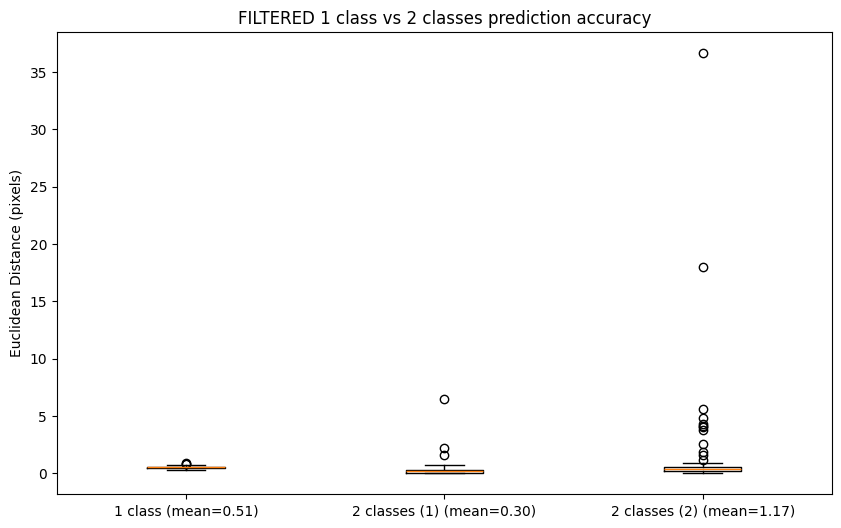

In [7]:
from accuracy_tests import get_euclidean_distance
import matplotlib.pyplot as plt

outputs_C = []
for batch in test_dataloader_C:
    data, *_ = batch
    output = lodestar2_C((data)).detach()
    outputs_C.append(output)

outputs_C = torch.cat(outputs_C, dim=0)

outputs_CE = []
for batch in test_dataloader_CE:
    data, *_ = batch
    output = lodestar2_CE((data)).detach()
    outputs_CE.append(output)

outputs_CE = torch.cat(outputs_CE, dim=0)

ed_1 = get_euclidean_distance(test_dataset_C, result_C, outputs_C, 1)
ed_2 = get_euclidean_distance(test_dataset_CE, result_CE, outputs_CE, 2)

# Reshape the data to 1D arrays
ed_1_reshaped = ed_1.view(100, -1).mean(dim=1).cpu().numpy()
ed_2_a_reshaped = ed_2[:, 0].mean(dim=1).cpu().numpy()
ed_2_b_reshaped = ed_2[:, 1].mean(dim=1).cpu().numpy()

print(ed_2_b_reshaped)
# ed_1_reshaped = ed_1_reshaped[ed_1_reshaped <= 1.5]
# ed_2_a_reshaped = ed_2_a_reshaped[ed_2_a_reshaped <= 1.5]
# ed_2_b_reshaped = ed_2_b_reshaped[ed_2_b_reshaped <= 1.5]

# Combine the lists into a single list for plotting
data_to_plot = [ed_1_reshaped, ed_2_a_reshaped, ed_2_b_reshaped]

# Calculate means
mean_ed_1 = ed_1_reshaped.mean()
mean_ed_2_a = ed_2_a_reshaped.mean()
mean_ed_2_b = ed_2_b_reshaped.mean()


# Create labels with the means
labels = [f'1 class (mean={mean_ed_1:.2f})', 
          f'2 classes (1) (mean={mean_ed_2_a:.2f})', 
          f'2 classes (2) (mean={mean_ed_2_b:.2f})']

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, labels=labels)
plt.title('FILTERED 1 class vs 2 classes prediction accuracy')
plt.ylabel('Euclidean Distance (pixels)')
plt.show()


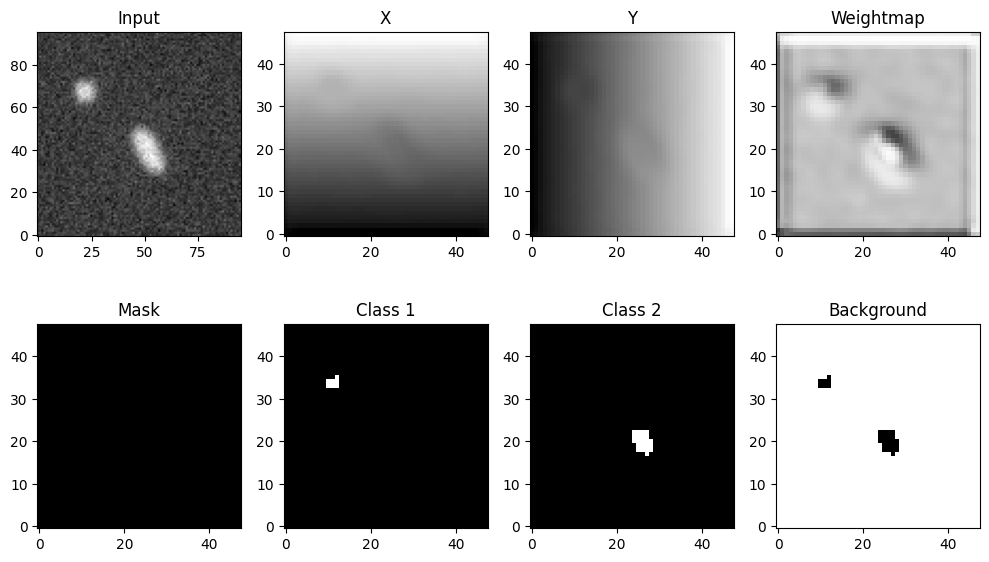

In [8]:
x = 22

plt.figure(figsize=(10, 6))
for i in range(8):
	plt.subplot(2, 4, i + 1)
	if i==0:
		plt.imshow(images_CE[x,...].squeeze(), cmap="gray", origin="lower")
		plt.title('Input')
	elif i==1:
		plt.imshow(outputs_CE[x,i-1,...], cmap="gray", origin="lower")
		plt.title('X')
	elif i==2:
		plt.imshow(outputs_CE[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Y')
	elif i==3:
		plt.imshow(outputs_CE[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		plt.title('Weightmap')
	elif i==4:
		plt.imshow(outputs_CE[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Mask')
	else:
		plt.imshow(outputs_CE[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		if i < 7:
			plt.title('Class ' + str(i-4))
		else:
			plt.title('Background')
	
plt.tight_layout()
plt.show()

## Plots

positions1 tensor([47.2608, 36.1540])
positions2 tensor([70.8109, 43.9735])
restult [[47.1271   36.35694 ]
 [74.324135 47.3347  ]
 [70.93782  43.77577 ]]


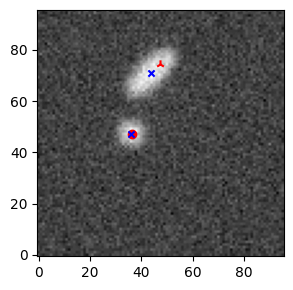

In [12]:
import matplotlib.pyplot as plt

x = 26
print("positions1",positions_CE_C[x])
print("positions2", positions_CE_E[x])
print("restult",result_CE[x])

plt.figure(figsize=(5, 3))
plt.imshow(images_CE[x,...].squeeze(), cmap="gray", origin="lower")
plt.scatter(result_CE[x][0][1], result_CE[x][0][0], c="r")
plt.scatter(result_CE[x][1][1], result_CE[x][1][0], c="r", marker='2')
plt.scatter(positions_CE_C[x][1], positions_CE_C[x][0], c="b", marker='x', s=20)
plt.scatter(positions_CE_E[x][1], positions_CE_E[x][0], c="b", marker='x', s=20)
plt.tight_layout()
plt.show()

position tensor([32.0917, 45.0667])
restult [[31.732702 44.348705]]


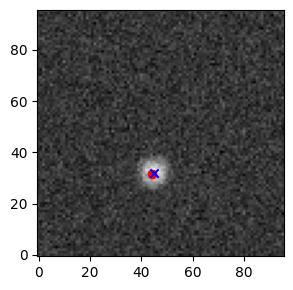

In [10]:
print("position",positions_C[0])
print("restult",result_C[0])

x = 0
plt.figure(figsize=(5, 3))
plt.imshow(images_C[x,...].squeeze(), cmap="gray", origin="lower")
plt.scatter(result_C[x][0][1], result_C[x][0][0], c="r")
plt.scatter(positions_C[x][1], positions_C[x][0], c="b", marker='x')
plt.tight_layout()
plt.show()